In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [3]:
df = pd.read_csv('./sample-mcd.csv', encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]

df['rating'] = df['rating'].apply(lambda x: int(x.split(" ")[0]))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,5 days ago,Made a mobile order got to the speaker and che...,1
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1


# Normalization

In [4]:
df_sm = df[['reviewer_id', 'review']].copy()

# Remove non-ASCII
df_sm['review_clean'] = df_sm['review'].apply(norm.remove_non_ascii)

# Expand contractions
df_sm['review_clean'] = df_sm['review_clean'].apply(norm.expand_contractions)

# Remove characters
df_sm['review_clean'] = df_sm['review_clean'].apply(norm.remove_characters, args=(True, ))

In [5]:
df_sm.head()

,reviewer_id,review,review_clean
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a..."


In [6]:
from transformers import pipeline

classifier = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def get_summarize(text, min_length=25, max_length=68):
    result = classifier(text, min_length=min_length, max_length=max_length)
    return result[0]['summary_text']

In [8]:
tqdm.pandas()
df_sm['summarize'] = df_sm['review_clean'].progress_apply(get_summarize)
print(df_sm.info())
df_sm.head()

 47%|██████████████████████████████████████                                           | 47/100 [03:37<03:19,  3.76s/it]Your max_length is set to 68, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:09<00:00,  4.89s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewer_id   100 non-null    int64 
 1   review        100 non-null    object
 2   review_clean  100 non-null    object
 3   summarize     100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
None


,reviewer_id,review,review_clean,summarize
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...,The staff at McDonalds are always friendly an...
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...,Never got the refund in the app. Made a mobil...
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,My mc. Crispy chicken sandwich was customer ...
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, ..."


In [9]:
# Sentence Tokenization
df_st = df_sm.copy()
df_st['token_sentence'] = df_st['summarize'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True, ))

# Lower text
# df_st['token_sentence'] = df_st['token_sentence'].apply(lambda x: x.lower())

# Lemmatization
df_st['token_lemma'] = df_st['token_sentence'].apply(norm.lemmatize_text)

# Get Aspect and Applied Sentiment Analysis (Rules Based)

In [10]:
# Get aspect from rules
tqdm.pandas()
df_st['aspect'] = df_st['token_lemma']\
                        .progress_apply(util.get_aspect_rules)

print(df_st.info())
df_st.head()

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:40<00:00,  9.53it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 385 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     385 non-null    int64 
 1   review          385 non-null    object
 2   review_clean    385 non-null    object
 3   summarize       385 non-null    object
 4   token_sentence  385 non-null    object
 5   token_lemma     385 non-null    object
 6   aspect          385 non-null    object
dtypes: int64(1), object(6)
memory usage: 24.1+ KB
None


,reviewer_id,review,review_clean,summarize,token_sentence,token_lemma,aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,Why does it look like someone spit on my food,why do it look like someone spit on my food,{someone spit}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,I had a normal transaction,i have a normal transaction,{normal transaction}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,everyone was chill and polite,everyone be chill and polite,{everyone}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,but now i dont want to eat this .,but now i dont want to eat this .,{}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,{clear substance}


In [11]:
df_st

,reviewer_id,review,review_clean,summarize,token_sentence,token_lemma,aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,Why does it look like someone spit on my food,why do it look like someone spit on my food,{someone spit}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,I had a normal transaction,i have a normal transaction,{normal transaction}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,everyone was chill and polite,everyone be chill and polite,{everyone}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,but now i dont want to eat this .,but now i dont want to eat this .,{}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,{clear substance}
...,...,...,...,...,...,...,...
98,99,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in t...,Allways also has the world's best fries and ic...,allways also have the world 's best fry and ic...,"{ice cream, best fry, allways}"
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great but they really need to hir...,Mcdonalds is great but they really need to hi...,Mcdonalds is great,mcdonalds be great,{mcdonalds}
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great but they really need to hir...,Mcdonalds is great but they really need to hi...,they really need to hire people who understand...,they really need to hire people who understand...,"{people, english}"
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great but they really need to hir...,Mcdonalds is great but they really need to hi...,The people are really nice,the people be really nice,{people}


In [12]:
mask = df_st['aspect'].apply(lambda x: False if len(x) == 0 else True).values

temp = df_st[mask].groupby(['reviewer_id'])\
                .agg({'token_sentence': lambda x: '.\n'.join(x),
                      'token_lemma': lambda x: '.\n'.join(x)})\
                .reset_index()

df_prc = df_st.groupby(['reviewer_id'])\
                .agg({'aspect': lambda x: set().union(*x),})\
                .reset_index()

df_prc = df_prc.merge(temp, on='reviewer_id', how='left').fillna("")

df_prc = df_sm.merge(df_prc, on='reviewer_id', how='left')
print(df_prc.info())
df_prc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     100 non-null    int64 
 1   review          100 non-null    object
 2   review_clean    100 non-null    object
 3   summarize       100 non-null    object
 4   aspect          100 non-null    object
 5   token_sentence  100 non-null    object
 6   token_lemma     100 non-null    object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB
None


,reviewer_id,review,review_clean,summarize,aspect,token_sentence,token_lemma
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,"{clear substance, someone spit, everyone, norm...",Why does it look like someone spit on my food....,why do it look like someone spit on my food.\n...
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...,The staff at McDonalds are always friendly an...,"{mcdonalds, atmosphere, staff, food}",The staff at McDonalds are always friendly and...,the staff at mcdonalds be always friendly and ...
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...,Never got the refund in the app. Made a mobil...,"{line, mobile order, money, refund}",Never got the refund in the app..\nMade a mobi...,never get the refund in the app ..\nmake a mob...
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,My mc. Crispy chicken sandwich was customer ...,"{service, crispy chicken, customer service, ch...",Crispy chicken sandwich was customer service ...,crispy chicken sandwich be customer service be...
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, ...","{order, large fry, large meal, close attention...",I repeat my order 3 times in the drive thru.\n...,i repeat my order 3 time in the drive thru.\ni...


In [13]:
df_prc['token_sentence'].iloc[0]

'Why does it look like someone spit on my food.\nI had a normal transaction.\neveryone was chill and polite.\nIm trying not to think about what this milky white/clear substance is all over my food'

In [14]:
df_prc['summarize'].iloc[0]

' Why does it look like someone spit on my food? I had a normal transaction,  everyone was chill and polite, but now i dont want to eat this . Im trying not to think about what this milky white/clear substance is all over my food, i d sure am not coming back .'

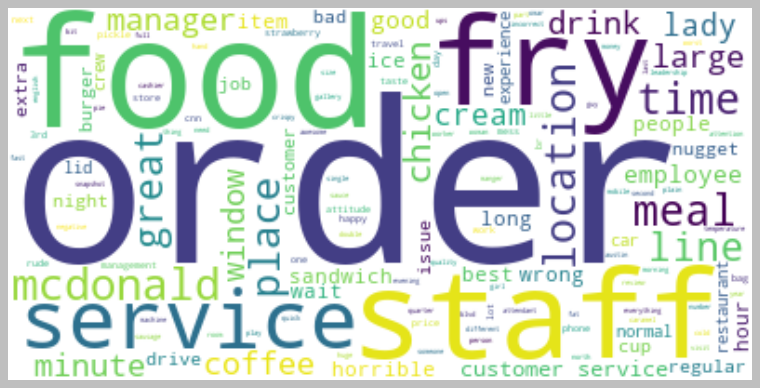

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_prc['aspect'].values
for i in range(df_prc.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Get Topic

In [16]:
# def get_optimum_lda(dictionary, corpus, texts, limit,
#                     start=2, step=1, get_result=False,
#                     iterations=20, passes=1):
#     coherence_values = []
    
#     for n in range(start, limit, step):
#         lda = gensim.models.LdaMulticore(corpus=corpus,
#                                          num_topics=n,
#                                          id2word=dictionary,
#                                          iterations=iterations,
#                                          passes=passes)
        
#         # Create coherence
#         coherence_model = CoherenceModel(model=lda, 
#                                          texts=texts,
#                                          dictionary=dictionary, 
#                                          coherence='c_v')
#         coherence_values.append(coherence_model.get_coherence())
    
    
#     opt_num_topics = start + coherence_values.index(max(coherence_values))
    
#     lda_opt = gensim.models.LdaMulticore(corpus=corpus,
#                                          num_topics=opt_num_topics,
#                                          id2word=dictionary)
    
#     if get_result:
#         print(coherence_values)
    
#     return lda_opt



In [17]:
# import gensim
# from gensim.models import CoherenceModel


# texts = df_prc['summarize'].apply(util.preprocess_lda)
# # texts = df_prc['sub_aspect'].apply(lambda x: ', '.join(list(x))).apply(util.preprocess_lda)

# dictionary = gensim.corpora.Dictionary(texts)

# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100_000)
# bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

# lda_opt = get_optimum_lda(dictionary, bow_corpus,
#                           texts, 10, get_result=True,
#                           passes=75, iterations=150)

In [18]:
# # Print topic
# for idx, topic in lda_opt.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

In [19]:
# def predict_topic(text):
#     text = util.preprocess_lda(text)
#     bow_vector = dictionary.doc2bow(text)
    
#     result = sorted(lda_opt[bow_vector], 
#                     key=lambda x: -1*x[1])[0][0]
    
#     return result
    
# # Extract keywords into a dictionary or list
# threshold = 0.05
# topics_dict = {}
# for topic_num, topic in lda_opt.show_topics(num_topics=10,
#                                                 num_words=10,
#                                                 formatted=False):
#     keywords = [word for word, w in topic if w > threshold]
#     topics_dict[topic_num] = keywords

In [20]:
# topics_dict

In [21]:
# tqdm.pandas()
# df_prc['topic'] = df_prc['summarize'].progress_apply(predict_topic)

In [22]:
# tqdm.pandas()
# df_prc['topic_keys'] = df_prc['topic'].progress_apply(lambda x: topics_dict[x])

In [23]:
# df_prc

# Save Result

In [24]:
# result = df_prc[['reviewer_id', 'review', 'summarize', 'aspect', 'topic_sentence', 'rating']].copy()
result = df_prc.drop('review_clean', axis=1).copy()
result = result.merge(df[['reviewer_id','rating']],
                      on='reviewer_id',
                      how='left')

result['aspect'] = result['aspect'].apply(lambda x: ', '.join(list(x)))
# result['sub_aspect'] = result['sub_aspect'].apply(lambda x: list(x))
# result['topic_keys'] = result['topic_keys'].apply(lambda x: ', '.join(x))

result.to_csv("./mcd_result/base_mcd.csv", index=False)